# Probability and land-use

_draft: need to add definition and method for logistic regression, revising river intersection and lenghts_

The introduction of a threshhold value for beach-litter density by the EU and the reasons for the application of that threshhold mark a change in the importance and use of beach litter data. Prior to the establishment of a threshold the primary use of beach-litter data was to _educate_ the public and in some instances define a link with mortality and mobidity of marine species. At present beach-litter survey results are also considered on the numerical distance from a stated goal. That goal is defined in __pieces of trash for every 100 m__. The goal is based on principal of precaution, that means we are unsure of the long term consequences and it would be best to minimize exposure if possible.[EU Threshold Value for Macro Litter on Coastlines](https://mcc.jrc.ec.europa.eu/main/dev.py?N=41&O=454)

With the announcement of threshhold value __there was no subsequent recomendation for changing the methods of sampling__. Consequently, this environmental assessment relies on the recorded observations of volunteers following a standard protocol. According to the journal [Nature](https://www.nature.com/articles/s41893-019-0390-3), programs that include the involvement of citizens in scientific research and/or knowledge production, can complement and ultimately improve the Sustainale Development Goals (SDG) reporting process. Beach litter applies specifically to SDG 14, __the target of achieving substantial reductions in marine pollution__.

## Motivation

Each encounter is local by definition (the location can be defined by a GPS point) and the time/date is unique for each survey for each person, or group of people doing a survey. Often the people that conduct the survey are beach-users themselves and local to the region. The encounter is the result of the desire of the person to remove these objects from the environment. __That is, the motivation to remove the object was present before the desire to record its existence__. 

### Proposition

1. Data from beach litter surveys can be used to estimate survey results at a local level.
   1. The municipal level: assisst with local mitigation and reduction efforts
   2. The method of inference should be adaptable to a a machine learning (ML) process

__assumptions__

1. reasonable people are collecting the data
2. protocols are followed
3. similar environmental conditions produce similar results
4. there is high varaibility in survey results
5. results represent the minimum number, the maximum is unknown
6. samples are independent
7. results are local

__Results are local:__ This means that events that produce large amounts of trash on the shoreline are possible at all moments. This includes thunderstorms, accidental spills, high-winds, local flood events or any event that includes consumption as a revenue source. It is also possible that a beach litter survey can yield extremely low results. __There is no immediate significance attached to the magnitude of a survey result. Extreme values are expected__.

## Methods of inference

The method of data collection asuggests a mathematical method of interpretation and analysis that is appropriate to real systems, can be tested empirically and allows reasonbale people to arrive at reasonable conclusions. Fortunately we don't need to invent a method, there are several appropriate techniques for arriving at a consensus estimate of a requested metric. (Maxwell, La Place, Bayes, Jaynes, Gelman, Savage).

### Binomial distribution

In the previous sections we were concerned with defining the relationship between the land use profile and the density of litter identified. This definition we limited to defining wether or not the quantity or magnitude of a type of land use was montotonic with litter density and if so what was the direction positive or negative. In this section, the question is more detailed and more specific:

1. How likely is a survey result to exceed a value given the land use profile of the survey location ?
2. __How likely is a survey result to exceed a threshold here and now ?__
   1. The land use profile is the collection of land use attriutes within a 3'000 m hex with the survey location at the middle. 
   2. __Here__ can be any location with a land-use profile that would also make an appropriate survey location
   3. __Now__ siginifies our expectations at the next survey.
   
This metric was introduced in the federal report as the fail-rate: _the number of times that at least one of an object was found at a survey_, all landuse values were consiered equal. This allowed us to select ojects of interest using frequency as a metric as well as quantity or density. Thus, it is easy to identify objects that are found frequently but not in large quantities. In this form the fail rate is also the most likely estimate (MLE) of the parameter _p_ for the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) that describes the probability of finding at least one of a requested object at a survey. How the fail rate can be used to determine a range of probable values for any object at any location was defined in, [finding one object](https://hammerdirt-analyst.github.io/finding-one-object/titlepage.html), the example was feminine hygiene products. 

### Odds and log odds

The odds of success are defined as the number of times that a test had a positive result v/s the number of times that the results were negative, or _k/(n-k)_. The probability of success can also be given as an _odds ratio:_ the probability of success divided by the probability of failure or $\frac{p}{1-p}$, where $p$ = the probability of success. Therefore, the log odds are _ln(_$\frac{p}{1-p}$_)_ or [Logit](https://en.wikipedia.org/wiki/Logit).

The log odds are used in [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), a commonly used method to model binary variables with multiple independent variables. In the case of beach litter data we are modeling the binary variable: "Did the survey result exceed the threshold?. Commonly used in machine learning models, logistic regression is often part of classification or labeling processes.

## Variables

1. independent variables: m² of each land use category, m of roads, m of rivers that intersect, m to river intersection point
2. outcome variable: binary, wether or not the threshold was exceeded at a survey
3. success: the threshold was exceeded = 1 else 0

__We assume that the land-use adjacent to the survey location and magnitudes of local river inputs are predictor varaibles for the amount of trash found on the shore line__.

## Data

### Survey data

The samples from the period 2020-2021 (IQAASL) for the following lakes are considered:

* Zurichsee
* Bielersee
* Neuenburgersee
* Walensee
* Vierwaldstattersee
* Brienzersee
* Thunersee
* Lac Léman
* Lago Maggiore
* Lago di Lugano
* Zugersee

In [1]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time
from os import listdir
from os.path import isfile, join
import typing

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import beta
from scipy.stats import binom
from scipy import optimize
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import resources.landuse_config as luse
import resources.empiricaldist as emp

import time

def retrieve_locations_by_bin(data, columns=["use", "binned"], use="Fels"):
    d = data.groupby(columns, as_index=False, dropna=False).location.unique()
    return d.loc[d.use == use].dropna()

def count_nk_bin(data, locations, agg={"k":"sum","n":"sum", "n-k":"sum"}):
    
    return data.loc[locations].agg(agg)

def collect_bin_data(tested, xtest):
    use = xtest.use.unique()
    binned = xtest.binned.unique()
    locations = xtest.location.values
    
    bins = []
    
    for i, anarray in enumerate(locations):
        
        a_count = count_nk_bin(tested, anarray)
        a_count["use"] = use[0]
        a_count["binned"] = binned[i]
        bins.append(a_count)
    return bins

def n_and_k_for_a_set_of_landuse_data(tested, binned_land_use_data):
    
    binned = []
    for use in binned_land_use_data.use.unique():
        locations_by_bin = retrieve_locations_by_bin(binned_land_use_data, use=use)
        bin_totals = collect_bin_data(tested, locations_by_bin)
        
        binned += bin_totals
        
        
    df = pd.DataFrame(binned)
    df = df.groupby(["use", "binned"], as_index=False).agg({"k":"sum","n":"sum", "n-k":"sum"})
    return df

# scaled prior



# survey data:
dfBeaches = pd.read_csv("resources/beaches.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('location', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description.copy()

# shorten the descriptions of two codes
code_d_map.loc["G38"] = "sheeting for protecting large cargo items"
code_d_map.loc["G73"] = "Foamed items & pieces (non packaging/insulation)"

# code material map
code_m_map = dfCodes.material

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

cmap = sns.diverging_palette(230, 20, as_cmap=True)

df = pd.read_csv('resources/surveys_iqaasl.csv')

# the lakes of interest
# collection points would be a good
# label. This is how they are considered in the model
# these locations serve as the endpoint for many 
# small rivers
collection_points = [
    'zurichsee',
    'bielersee',
    'neuenburgersee',
    'walensee',
    'vierwaldstattersee',
    'brienzersee',
    'thunersee',
    'lac-leman',
    'lago-maggiore',
    'lago-di-lugano',
    'zugersee'
]

# the data-frame of survey results to be considered
features_of_interest = collection_points
df = df[df.feature.isin(features_of_interest)]

# map the location to the name of the lake
wn_map = df[["location", "feature"]].drop_duplicates("location").set_index("location")
wn_map = wn_map["feature"]

In [2]:
# test the survey results of an object of interest
# against a threshhold
code="G30"
beach = 'mullermatte'
a_feature = 'bielersee'
survey_area = 'aare'


to_test = df[df.code == code].copy()
threshhold = to_test.pcs_m.median()
# The summary of the survey data
locations = df.location.unique()
samples = df.loc_date.unique()
lakes = df[df.w_t == "l"].drop_duplicates("loc_date").w_t.value_counts().values[0]
codes_identified = df[df.quantity > 0].code.unique()
codes_possible = df.code.unique()
total_id = df.quantity.sum()

data_summary = {
    "n locations": len(locations),
    "n samples": len(samples),
    "n lake samples": lakes,
    "n identified object types": len(codes_identified),
    "n possible object types": len(codes_possible),
    "total number of objects": total_id
}

pd.DataFrame(index = data_summary.keys(), data=data_summary.values()).style.set_table_styles(table_css_styles)

,0
n locations,93
n samples,331
n lake samples,331
n identified object types,205
n possible object types,230
total number of objects,52269


Each row of the survey data accounts for the quantity identified of a particular group of objects at a location on a given date. For example, there are 230 entries for each survey, representing the 230 possible groups an item can be placed in. Objects that were not identified are given the default quantity of zero. The unique indentifier for a survey is the combination of location and date (loc_date). For example consider the survey results from mullermatte on March 31, 2021:

In [3]:
sample_data = df[df.location == beach][["loc_date", "date", "location", "river_bassin", "feature", "city", "code", "pcs_m", "quantity"]]
sample_data.index.name = None
sample_data.head().style.set_table_styles(table_css_styles)

,loc_date,date,location,river_bassin,feature,city,code,pcs_m,quantity
3013,"('mullermatte', '2021-03-31')",2021-03-31,mullermatte,aare,bielersee,Biel/Bienne,G167,0.070000,3
3014,"('mullermatte', '2021-03-31')",2021-03-31,mullermatte,aare,bielersee,Biel/Bienne,G31,0.020000,1
3015,"('mullermatte', '2021-03-31')",2021-03-31,mullermatte,aare,bielersee,Biel/Bienne,G100,0.020000,1
3016,"('mullermatte', '2021-03-31')",2021-03-31,mullermatte,aare,bielersee,Biel/Bienne,G177,0.120000,5
3017,"('mullermatte', '2021-03-31')",2021-03-31,mullermatte,aare,bielersee,Biel/Bienne,G35,0.020000,1


### The land use data

How the land use is extracted from the map layers and schematic was demonstrated in the sections New Map data and River and Lake intersections. 

#### Aggregating, scaling and binning

__Aggregating the land use values:__ For land-cover objects the surface area of the polygon that defines each land use attribute that is bounded by the location hexagon is summed. For example their may be two different polygons that represent forest utilization within a hex, the sum of the two polygons is returned. Land cover objects include:

1. Buildings
2. Woods
3. Orchards
4. Wetlands
5. City center
6. Cliffs
7. Vineyards
8. Undefined

Land-use objects concern much smaller portions of the hex and represent specific land-use cases such as schools, hospitals or camping grounds. They have been aggregated in two categories for each hex:

1. Recreation
2. Infrastructure

__Scaling the land use values:__ The land-use and land-cover objects are scaled according to the proportion of the amount of land in the hex that is not covered by water.

__Binning the land use values:__ The scaled values were binned by quantile (.05) from zero to one. In other words there are twenty bins that group the land use and land cover values. Consider the land-use for Mullermatte below. The surface area 2'362'780 m² or 2.4 km². Scaled it is .51 or around the 50th percentile of all locations. It is in bin 11, this can be used to find other locations that have similar land-use values for city (next table).

In [4]:
# these are the land use values for each hex
# nutuzungsareal and freizeit areal are totaled
# the surface area of these two use cases gets added
# to the total of the land cover surface area
dfln = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-nutuzungsareal.csv")
dflf = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-freizeitareal.csv")

# rename the columns and total the surface are for each component
dflf.rename(columns={"OBJEKTART":"use"}, inplace=True)
dflf = dflf[~dflf.use.isin(['Reben', 'Obstanlage'])].copy()
dflf_t = dflf.groupby(["location", "river_bass", "city", "feature"], as_index=False).surface.sum()
dflf_t["use"] = "recreation"

dfln.rename(columns={"OBJEKTART":"use"}, inplace=True)
dfln = dfln[~dfln.use.isin(['Reben', 'Obstanlage'])].copy()
dfln_t = dfln.groupby(["location", "river_bass", "city", "feature"], as_index=False).surface.sum()
dfln_t["use"] = "infrastructure"

# combine the data frames
rec_inf = pd.concat([dfln_t, dflf_t])
rec_inf = rec_inf[rec_inf.location.isin(locations)]

# this is the land cover, the total surface area of the hex is accounted for here
# this includes the surface area of the lake within the hex
# there are portions of the map layer that have no land-use attribute
# to account for this, the total surface area of all labeled sections is 
# substracted from the area of a hex 5845672 m². This attribute is labled 
# undefined
dflc = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-landcover.csv")

# sum the unique land cover values for each location
area_of_a_hex = 5845672
xgr = dflc.groupby(["location", "city", "river_bass","lat", "lon", "feature", "OBJVAL"], as_index=False, dropna=False).surface.sum()

# the sum of all the land cover values for a location
xgrt = xgr.groupby(["location", "city", "river_bass","lat", "lon", "feature"], as_index=False).surface.sum()

# the amount of surface area that is not accounted for 
xgrt["undefined"] = area_of_a_hex - xgrt.surface

# format data frame to join to the other land cover totals
xgrt["OBJVAL"] = "undefined"
xgrt["surface"] = xgrt["undefined"]
xgrt.drop("undefined", inplace=True, axis=1)

# add to other totals
dflcx = pd.concat([xgr, xgrt])

# remove the value of See from the surface area of a hex.
# We are considering the magnitude of land use type in relation
# to the amount of land that is available to be used, not including 
# amount of land that is covered by the lake itself
xsee = xgr[xgr.OBJVAL == "See"][["location", "surface"]]
xsee["hex minus"] = area_of_a_hex - xsee.surface
hex_minus = xsee[["location", "hex minus"]].set_index("location", drop=True)

# map the adjusted surface area to to the land use
# totals and scale the surface column to the adjusted surface area
dflcx["hex minus"] = dflcx.location.apply(lambda x: hex_minus.loc[x, "hex minus"])
# change column name
dflcx.rename(columns={"OBJVAL":"use"}, inplace=True)

# add the land use attributes to the land-cover data
rec_inf["hex minus"] = rec_inf.location.apply(lambda x: hex_minus.loc[x, "hex minus"])

columns = ["location", "river_bass", "city", "feature", "surface", "use", "hex minus"]

agg_land_use = pd.concat([dflcx[columns], rec_inf[columns]])

agg_land_use["scaled"] = agg_land_use.surface/agg_land_use["hex minus"]

# remove See from the data frame
agg_land_use = agg_land_use[agg_land_use.use != "See"]

bind = bins = pd.IntervalIndex.from_tuples([(-1, 0), (0.00000001, .049999), (.05000, .099999), (.10000, .149999),(.15000, .199999), (.2, .2499), (.25, .2999), (.3000, .3499),
        (.35, .3999), (.4000, .449999), (.45, .499999),(.5, .549999), (.55, .5999), (.6000, .6499), (.65, .6999), (.7, .7499), (.75, .7999),
        (.8, .8499), (.85, .8999), (.9, .9499), (.95, 1)])

# bin the scaled column

sbins = pd.cut(agg_land_use.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbins=sbins.cat.rename_categories(np.arange(start=0, stop=21))

agg_land_use["binned"] = sbins

aglu = agg_land_use.copy()
aglu = aglu[aglu.location.isin(df.location.unique())]
sample_data = aglu[aglu.location == beach][["use", "river_bass", "location", "city", "feature", "hex minus", "surface", "scaled", "binned"]].set_index("use", drop =True)
sample_data.index.name = None
sample_data.style.set_table_styles(table_css_styles)

,river_bass,location,city,feature,hex minus,surface,scaled,binned
Siedl,aare,mullermatte,Biel/Bienne,bielersee,4602265,2362780,0.513395,11
Stadtzentr,aare,mullermatte,Biel/Bienne,bielersee,4602265,34237,0.007439,1
Wald,aare,mullermatte,Biel/Bienne,bielersee,4602265,1928607,0.419056,9
Fels,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0
Obstanlage,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0
Reben,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0
Sumpf,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0
undefined,aare,mullermatte,Biel/Bienne,bielersee,4602265,276641,0.060110,2
infrastructure,aare,mullermatte,Biel/Bienne,bielersee,4602265,186185,0.040455,1
recreation,aare,mullermatte,Biel/Bienne,bielersee,4602265,138729,0.030144,1


_Survey locations that have similar amounts of __Urban__ land use within location hex_

In [5]:
# other locations with similar land-cover attriutes
aglu[(aglu.use == 'Siedl')&(aglu.binned == 11)].style.set_table_styles(table_css_styles)

,location,river_bass,city,feature,surface,use,hex minus,scaled,binned
593,mullermatte,aare,Biel/Bienne,bielersee,2362780,Siedl,4602265,0.513395,11
617,nouvelle-plage,aare,Estavayer,neuenburgersee,1517551,Siedl,2860919,0.530442,11
963,tolochenaz,rhone,Tolochenaz,lac-leman,1733621,Siedl,3216699,0.538944,11


_Survey locations that have similar amounts of __Forest__ land use within location hex_

In [6]:
aglu[(aglu.use == 'Wald')&(aglu.binned == 9)].style.set_table_styles(table_css_styles)

,location,river_bass,city,feature,surface,use,hex minus,scaled,binned
275,gasi-strand,linth,Weesen,walensee,1628315,Wald,3800608,0.428435,9
386,lacleman_gland_lecoanets,rhone,Gland,lac-leman,1259466,Wald,3091169,0.407440,9
556,magadino-lido,ticino,Gambarogno,lago-maggiore,1491775,Wald,3599319,0.414460,9
579,mols-rocks,linth,Quarten,walensee,1460847,Wald,3514935,0.415611,9
586,muhlehorn-dorf,linth,Glarus Nord,walensee,1302522,Wald,3158628,0.412370,9
595,mullermatte,aare,Biel/Bienne,bielersee,1928607,Wald,4602265,0.419056,9
602,murg-bad,linth,Quarten,walensee,1029136,Wald,2521874,0.408084,9


Note that the only common element of the two preceeding tables is the location in question.

In [7]:
tested = luse.test_one_object(to_test, threshhold, "location")
f = n_and_k_for_a_set_of_landuse_data(tested, aglu)

aglu["k"] = aglu.apply(lambda row: f.loc[(f.use == row["use"])&(f.binned == row["binned"])].values[0][2], axis=1)
aglu["n"] = aglu.apply(lambda row: f.loc[(f.use == row["use"])&(f.binned == row["binned"])].values[0][3], axis=1)
aglu["n-k"] = aglu.apply(lambda row: f.loc[(f.use == row["use"])&(f.binned == row["binned"])].values[0][4], axis=1)

## Testing the threshold

To test a threshhold the survey results for the object of interest at each location are compared to the threshhold value. The number of times that the threshold value was exceeded (success) is counted for each location and sample. The number of samples for each location is also recorded. The result is an indexed data frame that contains the number of successes and samples for each location.

For example consider the results for locations with similar urban land-use characteristics as mullermatte:

In [8]:
# other locations with similar land-cover attriutes
tone = tested.loc[aglu[(aglu.binned==11)&(aglu.use == 'Siedl')].location.unique()].style.set_table_styles(table_css_styles)
tone.index.name = None
tone

,k,n,n-k,k/n
mullermatte,10,12,2,0.833333
nouvelle-plage,0,1,1,0.000000
tolochenaz,0,1,1,0.000000


These results reprsent the number of times that a threshold value was exceeded (k) and the number of samples (n) at each location. When the survey results are merged with the land-use values for each location the result is the number of times that threshhold value was exceeded for the range of land use values contained in the bin: 

In [9]:
sample_data = aglu[(aglu.binned == 11)&(aglu.use == 'Siedl')]
sample_data = sample_data[["use", "location", "hex minus", "surface", "scaled", "binned", "k", "n", "n-k"]]
sample_data.set_index("use", drop =True, inplace=True)
sample_data.index.name = None
sample_data.style.set_table_styles(table_css_styles)

,location,hex minus,surface,scaled,binned,k,n,n-k
Siedl,mullermatte,4602265,2362780,0.513395,11,10,14,4
Siedl,nouvelle-plage,2860919,1517551,0.530442,11,10,14,4
Siedl,tolochenaz,3216699,1733621,0.538944,11,10,14,4


__Interpretation:__ Locations where the scaled surface area classified as urban is between .5 and .55 (bin 11) exceeded the threshold value 10/14 times. 

When this process is repeated for all locations and all land-use values, the record of success for each location can be considered in terms of the global record of success, given the land use characteristics:

In [10]:
sample_data = aglu[aglu.location == beach][["use", "river_bass", "location", "city", "feature", "hex minus", "surface", "scaled", "binned", "k", "n", "n-k"]].set_index("use", drop =True)
sample_data.index.name = None
sample_data.style.set_table_styles(table_css_styles)

,river_bass,location,city,feature,hex minus,surface,scaled,binned,k,n,n-k
Siedl,aare,mullermatte,Biel/Bienne,bielersee,4602265,2362780,0.513395,11,10,14,4
Stadtzentr,aare,mullermatte,Biel/Bienne,bielersee,4602265,34237,0.007439,1,16,20,4
Wald,aare,mullermatte,Biel/Bienne,bielersee,4602265,1928607,0.419056,9,14,31,17
Fels,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0,145,281,136
Obstanlage,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0,136,273,137
Reben,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0,119,257,138
Sumpf,aare,mullermatte,Biel/Bienne,bielersee,4602265,0,0.000000,0,127,247,120
undefined,aare,mullermatte,Biel/Bienne,bielersee,4602265,276641,0.060110,2,11,16,5
infrastructure,aare,mullermatte,Biel/Bienne,bielersee,4602265,186185,0.040455,1,99,216,117
recreation,aare,mullermatte,Biel/Bienne,bielersee,4602265,138729,0.030144,1,122,243,121


### The odds and frequency of exceeding the threshold

Given the values in the preceeding table an initial assesment of the frequency (k/n) and the odds (k/(n-k)) of exceeding the threshold can be made.

__The expected frequency__ (k/n) that a survey result will exceed the threshhold value for a particular land use group is given in the table below.

1. all data = all the results and all land use values, the median of all data
2. survey area = the survey results from the survey area, given the land use conditions of the survey area
3. lake = the survey results from the lake, given the land use conditions of the lake
4. location = the survey results from the locations with similar land-use features as mullermatte (including mullermatte)

__Remarks__: We expect the median value to be exceeded 50% of the time when all data is considered. The frequency that the threshhold will be exceeded within the survey area is lower than the rest of the data for the following land-use attributes:

1. Orchard
2. Urban
3. Forest
4. Infrastructure

At the lake level, values greater than the median should be expected for wetlands. For locations that have similar characteristics the urbanization (city, city center) and undefined areas should expect values greater than the median.

Compared to the reported median of the lakes and rivers in the Aare survey area ([Results Aare Survey area](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/aare_sa.html)), we would expect the frequency that the threshhold is exceeded to be less than all-data in the Aare survey area given that the reported median for the same object is less in the Aare survey area.

In [11]:
def collect_odds_frequency(data):
    data["odds"] = data["k"]/data["n-k"]
    data["frequency"] = data["k"]/data["n"]
    
    return data

def land_use_odds_frequency(data, rb, feature, location):
    agg_cols = {"k":"sum", "n": "sum", "n-k": "sum"}
    
    dall = data.drop_duplicates(["use", "binned"])
    dall = dall.groupby("use", dropna=False).agg(agg_cols)
    dall = collect_odds_frequency(dall)
    
    drb = data[data.river_bass == rb].drop_duplicates(["use", "binned"])
    drb = drb.groupby("use", dropna=False).agg(agg_cols)
    drb = collect_odds_frequency(drb)
    
    dfeat = data[data.feature == feature].drop_duplicates(["use", "binned"])
    dfeat = dfeat.groupby("use", dropna=False).agg(agg_cols)
    dfeat = collect_odds_frequency(dfeat)
    
    dloc = data[data.location == location].drop_duplicates(["use", "binned"])
    dloc = dloc.groupby("use", dropna=False).agg(agg_cols)
    dloc = collect_odds_frequency(dloc)
    
    return dall, drb, dfeat, dloc

def summary_table_odds_frequency(dall, drb, dfeat, dloc, column="odds", labels=["all data", "rb", "feature", "location"]):    
    
    dall.rename(columns={column:labels[0]}, inplace=True)
    drb.rename(columns={column:labels[1]}, inplace=True)
    dfeat.rename(columns={column:labels[2]}, inplace=True)
    dloc.rename(columns={column:labels[3]}, inplace=True)
    summary = pd.concat([dall[labels[0]], drb[labels[1]], dfeat[labels[2]], location[labels[3]]], axis=1).fillna(0)
    
    return summary

    
aglu_totals = aglu.drop_duplicates(["use", "binned"])

all_data, r_bas, feature, location = land_use_odds_frequency(aglu, survey_area, a_feature, beach)

summary_frequency = summary_table_odds_frequency(all_data, r_bas, feature, location, column="frequency", labels=["all data", "survey area","lake", "location"])
summary_frequency.index.name = None

def style_frequency(v, props=''):
    return props if v >= .51  else None
# s2 = df2.style.applymap(style_negative, props='color:red;')\
#               .applymap(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)
# s2
# sodds = summary_odds.style.format(precision=2) # 
s_frequency = summary_frequency.style.format(precision=2).applymap(style_frequency, props='color:red;')
s_frequency.applymap(lambda v: 'opacity: 20%;' if (v <= 0.515) and (v > 0.495) else None)

,all data,survey area,lake,location
Fels,0.50,0.50,0.51,0.52
Obstanlage,0.49,0.48,0.49,0.50
Reben,0.50,0.50,0.50,0.46
Siedl,0.49,0.48,0.41,0.71
Stadtzentr,0.50,0.49,0.49,0.80
Sumpf,0.50,0.49,0.52,0.51
Wald,0.49,0.46,0.38,0.45
infrastructure,0.49,0.46,0.47,0.46
recreation,0.49,0.50,0.50,0.50
undefined,0.49,0.50,0.48,0.69


__The expected odds:__ are similar to the expected frequency. Notably for this location urbanization, city center and undefined land use attributes increase the odds in favor of exceeding the threshold value by more than 2/1. 

In [12]:
all_data, r_bas, feature, location = land_use_odds_frequency(aglu, survey_area, a_feature, beach)
summary_odds = summary_table_odds_frequency(all_data, r_bas, feature, location, column="odds", labels=["all data", "survey area","lake", "location"])
summary_odds.index.name = None

def style_odds(v, props=''):
    return props if v >= 1  else None

sodds = summary_odds.style.format(precision=2).applymap(style_odds, props='color:red;')
sodds.applymap(lambda v: 'opacity: 20%;' if (v < 1.008) and (v >= .99) else None)

,all data,survey area,lake,location
Fels,0.99,0.99,1.06,1.07
Obstanlage,0.98,0.92,0.98,0.99
Reben,0.99,0.99,0.99,0.86
Siedl,0.97,0.92,0.68,2.50
Stadtzentr,0.99,0.98,0.95,4.00
Sumpf,0.99,0.98,1.10,1.06
Wald,0.97,0.84,0.60,0.82
infrastructure,0.97,0.86,0.88,0.85
recreation,0.97,0.98,1.01,1.01
undefined,0.97,0.99,0.92,2.20


__Interpretation:__ We do expect to exceed the national median the Aare survey area. At the lake level there are conditions that suggest the median value will be exceeded. However, we do not expect to exceed the median in most cases. For this location in particular we expect the median value to be exceeded frequently. The main causes could be attributed to the runoff from the urban center, increased use of recreational areas and appropriation or use of undefined areas within the hexagon that surrounds mullermatte. 

### The probability of exceeding the threshold

The probability of exceeding the threshhold can be written as a conditional probability statement. Substituting our variables in to Bayes' Theorem we get:

$$p(\theta | landuse) = \frac{p(landuse|\theta)*p(\theta)}{p(landuse)}$$

This is read as the probability of exceeding the threshold given the land-use conditions $p(\theta | landuse)$ is equal to the product of  the probability that the threshold was exceeded for a land-use condition given the proabability of exceeding the threshold $p(landuse|\theta)$ and the probability of exceeding the threshhold $p(\theta)$, divided by the probability of exceeding the threshold under all land-use condtions $p(landuse)$. ([Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) ([conditional proabability](https://en.wikipedia.org/wiki/Conditional_probability))

The terms of this relationship can be labled in the following way:

1. Conditional probability of interest (posterior) = $p(\theta | landuse)$
2. Likelihood = $p(landuse|\theta)$
3. Prior = $p(\theta)$
4. Marginal probability of the data = $p(landuse)$


#### The prior

The prior is $p(\theta)$ which we define as __the probability of exceeding the threshhold at the parent aggregation level__. That is we consider the the probability of exceeding the threshhold in the survey area by considering the results at the survey area and taking the results of all the data as prior knowledge.

$$p(\theta_{survey area} | landuse_{surveyarea}) = \frac{p(landuse_{surveyarea}|\theta_{surveyarea})*p(\theta_{alldata})}{p(landuse_{surveyarea})}$$

Then the probability of exceeding the threshold in the survey area is used as the prior for the lake:

$$p(\theta_{lake} | landuse_{lake}) = \frac{p(landuse_{lake}|\theta_{lake})*p(\theta_{surveyarea})}{p(landuse_{lake})}$$

__Scaling the prior__ means optimizing the parameters of the Beta function in such away that the _prior_ results do not overwhelm the survey results or the inverse. For example at the lake level k=1'220 and n=2'524 but the results for mullermatte are k=10 and n=12. The known values (our prior lake data) is two orders of magnitude greater than our sample results.  

$$ E[Beta(1'220, (2'524-1'220))] \approx 0.483359746 \approx E[Beta(11.587249777917547, 12.385060418239757)] $$

In other words we can use different values of n and k to get the same expected results from the Beta distribution. The orginal values are optimized by finding the minimum values for n and (n-k) that satisfy the above requirements. ([Optimization and Roots](https://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding)) ([Root method](https://docs.scipy.org/doc/scipy/reference/optimize.root-hybr.html#optimize-root-hybr)) ([Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method))

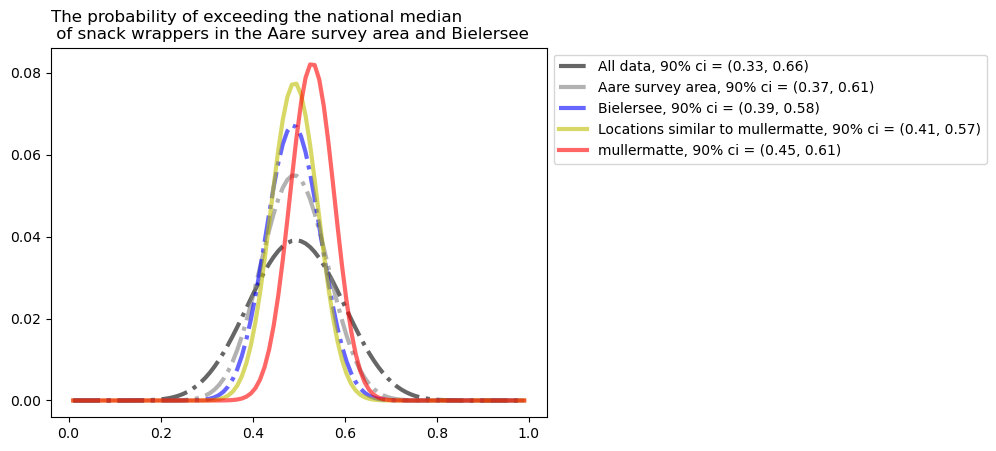

In [13]:
# calculating the probability of exceeding the threshold

def minimize_alpha_beta_beta(x, mu, var):
    
    alpha, beta = x[0], x[1]
        
    # define the mean and variance in terms of the parameters
    # mean or mu
    m = alpha/(alpha+beta)    
    
    # standard deviation
    v =  (alpha*beta)/(((alpha+beta)**2)*(alpha+beta+1))
    
    return [m - mu, v - var]

def getAlphaBeta(mu, sigma):
    
    alpha = mu**2 * ((1 - mu) / sigma**2 - 1 / mu)

    beta = alpha * (1 / mu - 1)

    return alpha, beta

def update_alpha_beta_for_a_code(data, scale: bool=True, start_scale = [1, 1]):
    
    k, n = data    
    mu = data[0]/data[1]
    
    if mu == 0:
        print("mu is zero")
        mu = 0.0001
    var = (data[0]*(data[1] - data[0]))/((data[0] + (data[1]-data[0]))**2*(data[0] + (data[1]-data[0]) + 1))
    
    if var < 0.01:
        var = 0.01
    a, b = getAlphaBeta(mu, var) 
    
    kscaled, nscaled = optimize.root(minimize_alpha_beta_beta, start_scale, args=(mu, var)).x
    
    return k,n, kscaled, nscaled, a,b, mu, var

def make_beta(k, n_minus_k):
    """Makes a beta object."""
    dist = beta(k, n_minus_k)
    dist.alpha = k
    dist.beta = n_minus_k
    return dist

def update_beta(prior, data):
    """Update a beta distribution."""
    k, n_minus_k = data
    alpha = prior.alpha + k
    beta = prior.beta + n_minus_k
    return make_beta(alpha, beta)

def y_prior(data):
    observed_alpha, observed_beta = data.k.sum(), data.n.sum()
    k,n, kscaled, nscaled, a,b, mu, var = update_alpha_beta_for_a_code((observed_alpha, observed_beta))
    prior_beta = make_beta(kscaled, nscaled)
        
    return prior_beta

def updated_prior(prior, data, scaled: bool=True):
    xs = np.linspace(0.01, 0.99, 101)
    observed_alpha, observed_beta = data.k.sum(), data.n.sum()
    k,n, kscaled, nscaled, a,b, mu, var = update_alpha_beta_for_a_code((observed_alpha, observed_beta))
    if scaled:
        updated_prior = update_beta(prior, (kscaled, nscaled))
    else:
        updated_prior = update_beta(prior, (k, n - k))
        
    yupdated = [updated_prior.pdf(x) for x in xs]
    
    return updated_prior, yupdated


# probability of exceeding the threshold for all data
xs = np.linspace(0.01, 0.99, 100)
observed_alpha, observed_beta = all_data.k.sum(), all_data.n.sum()
k,n, kscaled, nscaled, a,b, mu, var = update_alpha_beta_for_a_code((observed_alpha, observed_beta))
a_prior = make_beta(.5, .5)
prior_beta = update_beta(a_prior, (kscaled, nscaled))
yprior = [prior_beta.pdf(x) for x in xs]

# probability of exceeding the threshold for the survey area
observed_alpha, observed_beta = r_bas.k.sum(), r_bas.n.sum()
k,n, kscaled, nscaled, a,b, mu, var = update_alpha_beta_for_a_code((observed_alpha, observed_beta))
rbass_probs = update_beta(prior_beta, (kscaled, nscaled))
yrbass = [rbass_probs.pdf(x) for x in xs]

# probability of exceeding the threshhold for the lake
observed_alpha, observed_beta = feature.k.sum(), feature.n.sum()
k,n, kscaled, nscaled, a,b, mu, var = update_alpha_beta_for_a_code((observed_alpha, observed_beta))
lake_probs = update_beta(rbass_probs, (kscaled, nscaled))
y1 = [lake_probs.pdf(x) for x in xs]

# probability of exceeding the threshhold for similar locations
observed_alpha, observed_beta = location.k.sum(), location.n.sum()
k,n, kscaled, nscaled, a,b, mu, var = update_alpha_beta_for_a_code((observed_alpha, observed_beta))
location_probs = update_beta(lake_probs, (kscaled, nscaled))
y2 = [location_probs.pdf(x) for x in xs]

# probability of exceeding the threshhold for mullermatte
observed_alpha, observed_beta = tested.loc[beach].k.sum(), tested.loc[beach].n.sum()
k,n, kscaled, nscaled, a,b, mu, var = update_alpha_beta_for_a_code((observed_alpha, observed_beta))
expected_probs = update_beta(location_probs, (k, n - k))
y3 = [expected_probs.pdf(x) for x in xs]

fig, ax=plt.subplots()

yprior_e = tuple(np.round(prior_beta.interval(.9), 2))
rbas_prior = tuple(np.round(rbass_probs.interval(.9), 2))
lake_prior = tuple(np.round(lake_probs.interval(.9), 2))
location_prior = tuple(np.round(location_probs.interval(.9), 2))
expected = tuple(np.round(expected_probs.interval(.9), 2))

ax.set_title("The probability of exceeding the national median\n of snack wrappers in the Aare survey area and Bielersee", loc='left')

ax.plot(xs, yprior/sum(yprior), 'black', linestyle='-.', lw=3, alpha=0.6, label=f'All data, 90% ci = {yprior_e}')
ax.plot(xs, yrbass/sum(yrbass), 'gray', lw=3, linestyle='-.', alpha=0.6, label=f'Aare survey area, 90% ci = {rbas_prior}')
ax.plot(xs, y1/sum(y1), 'b', lw=3, linestyle='-.', alpha=0.6, label=f'Bielersee, 90% ci = {lake_prior}')
ax.plot(xs, y2/sum(y2), 'y-', lw=3, alpha=0.6, label=f'Locations similar to mullermatte, 90% ci = {location_prior}')
ax.plot(xs, y3/sum(y3), 'r-', lw=3, alpha=0.6, label=f'{beach}, 90% ci = {expected}')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.show()

### Logistic regression

### Infrastructure

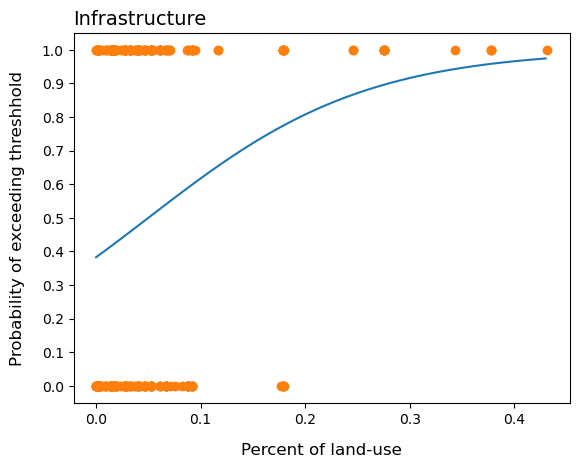

In [14]:
import statsmodels.formula.api as smf
from scipy.special import expit

log_of = to_test[["location", "k"]].copy()
log_of["failed"] = log_of.k.astype(int)
log_of = log_of[["location", "failed"]]
ict = aglu[aglu.use == "infrastructure"][["location", "scaled"]].set_index("location")
ict = ict["scaled"]
log_of["infrastructure"] = log_of.location.apply(lambda x: ict.loc[x])


obj_min, obj_max = log_of.infrastructure.min(), log_of.infrastructure.max()

formula = 'failed ~ infrastructure'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['infrastructure']
xs = np.arange(obj_min, obj_max, step=.01)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["infrastructure"], log_of["failed"], 'o')
ax.set_title("Infrastructure", fontsize=14, loc='left')

ax.set_xlabel("Percent of land-use", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Urbanization

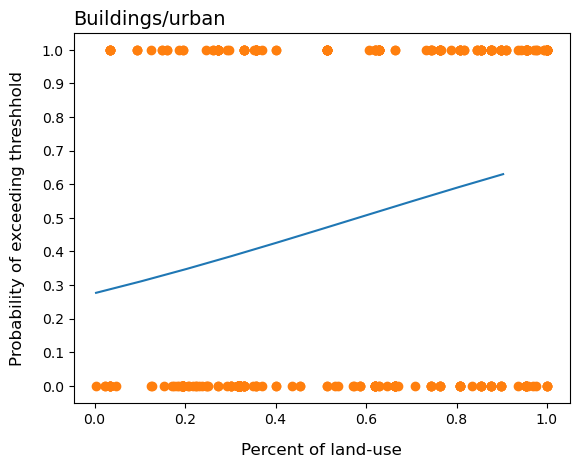

In [15]:
log_of = to_test[["location", "k"]].copy()
log_of["failed"] = log_of.k.astype(int)
log_of = log_of[["location", "failed"]]

ict = aglu[aglu.use == "Siedl"][["location", "scaled"]].set_index("location")
ict = ict["scaled"]
log_of["Siedl"] = log_of.location.apply(lambda x: ict.loc[x])

obj_min, obj_max = log_of.Siedl.min(), log_of.Siedl.max()

formula = 'failed ~ Siedl'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Siedl']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["Siedl"], log_of["failed"], 'o')
ax.set_title("Buildings/urban", fontsize=14, loc='left')

ax.set_xlabel("Percent of land-use", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Forest

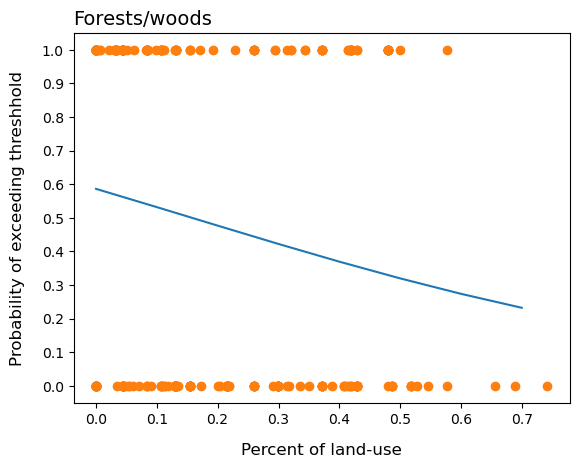

In [16]:
log_of = to_test[["location", "k"]].copy()
log_of["failed"] = log_of.k.astype(int)
log_of = log_of[["location", "failed"]]

ict = aglu[aglu.use == "Wald"][["location", "scaled"]].set_index("location")
ict = ict["scaled"]
log_of["Wald"] = log_of.location.apply(lambda x: ict.loc[x])

obj_min, obj_max = log_of.Wald.min(), log_of.Wald.max()

formula = 'failed ~ Wald'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Wald']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["Wald"], log_of["failed"], 'o')
ax.set_title("Forests/woods", fontsize=14, loc='left')

ax.set_xlabel("Percent of land-use", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Undefined

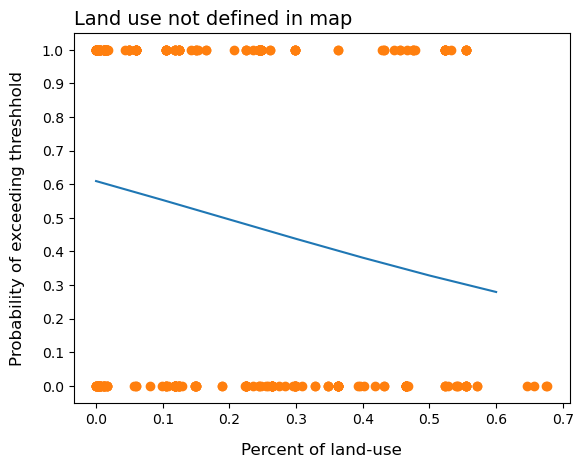

In [17]:
log_of = to_test[["location", "k"]].copy()
log_of["failed"] = log_of.k.astype(int)
log_of = log_of[["location", "failed"]]

ict = aglu[aglu.use == "undefined"][["location", "scaled"]].set_index("location")
ict = ict["scaled"]
log_of["Undefined"] = log_of.location.apply(lambda x: ict.loc[x])

obj_min, obj_max = log_of.Undefined.min(), log_of.Undefined.max()

formula = 'failed ~ Undefined'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Undefined']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["Undefined"], log_of["failed"], 'o')
ax.set_title("Land use not defined in map", fontsize=14, loc='left')

ax.set_xlabel("Percent of land-use", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Recreation

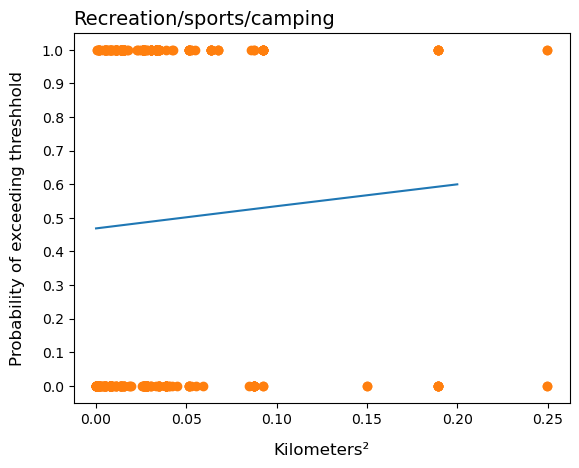

In [18]:
log_of = to_test[["location", "k"]].copy()
log_of["failed"] = log_of.k.astype(int)
log_of = log_of[["location", "failed"]]

ict = aglu[aglu.use == "recreation"][["location", "scaled"]].set_index("location")
ict = ict["scaled"]
log_of["recreation"] = log_of.location.apply(lambda x: ict.loc[x])

obj_min, obj_max = log_of.recreation.min(), log_of.recreation.max()

formula = 'failed ~ recreation'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['recreation']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["recreation"], log_of["failed"], 'o')
ax.set_title("Recreation/sports/camping", fontsize=14, loc='left')

ax.set_xlabel("Kilometers²", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Distance to river intersection

_Currently being edited_

In [19]:
# log_of = to_test[["location", "failed"]].copy()

# log_of["r-distance"] = log_of.location.apply(lambda x: dist_ct.loc[dist_ct.location == x, "r-distance"].values[0])
# log_of["r-distance"] = log_of["r-distance"]/1000
# log_of.rename(columns={'r-distance':'r_distance'}, inplace=True)

# obj_min, obj_max = log_of["r_distance"].min(), log_of["r_distance"].max()

# formula = 'failed ~ r_distance'
# results = smf.logit(formula, data=log_of).fit(disp=False)
# inter = results.params['Intercept']
# slope = results.params['r_distance']
# xs = np.arange(obj_min, obj_max, step=.1)

# log_odds = inter + slope * xs
# odds = np.exp(log_odds)

# ps_x = expit(inter + slope * xs)

# fig, ax = plt.subplots()

# ax.plot(xs, ps_x)
# ax.plot(log_of["r_distance"], log_of["failed"], 'o')
# ax.set_title("Distance to river intersection", fontsize=14, loc='left')

# ax.set_xlabel("Kilometers", fontsize=12,labelpad=12)
# ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
# plt.show()

### Length of river intersects

_Currently being edited_

In [20]:
# log_of = to_test[["location", "failed"]].copy()

# log_of["r-length"] = log_of.location.apply(lambda x: ints_ct.loc[ints_ct.location == x, "r-length"].values[0])
# log_of["r-length"] = log_of["r-length"]/1000
# log_of.rename(columns={'r-length':'r_length'}, inplace=True)

# obj_min, obj_max = log_of["r_length"].min(), log_of["r_length"].max()

# formula = 'failed ~ r_length'
# results = smf.logit(formula, data=log_of).fit(disp=False)
# inter = results.params['Intercept']
# slope = results.params['r_length']
# xs = np.arange(obj_min, obj_max, step=.1)

# log_odds = inter + slope * xs
# odds = np.exp(log_odds)

# ps_x = expit(inter + slope * xs)

# fig, ax = plt.subplots()

# ax.plot(xs, ps_x)
# ax.plot(log_of["r_length"], log_of["failed"], 'o')
# ax.set_title("Length of intersecting rivers in buffer", fontsize=14, loc='left')

# ax.set_xlabel("Kilometers", fontsize=12,labelpad=12)
# ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
# plt.show()

In [21]:
threshhold

0.11

In [22]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 23/05/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [23]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/landuse.git

Git branch: probability

IPython    : 8.12.0
PIL        : 9.5.0
numpy      : 1.24.2
seaborn    : 0.12.2
matplotlib : 3.7.1
statsmodels: 0.13.5
scipy      : 1.10.1
pandas     : 2.0.0
json       : 2.0.9

